# 09_LDA_Exploration
## Ray Hossain


## Setup

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv("Processed_Data/80_TopicLDA_Long.csv")

In [3]:
#data.head()

In [4]:
data['secondvote'] = data['secondvote'].replace(7,0)
data['secondvote'].value_counts()

secondvote
2    116470
1     71773
6     63431
5     60259
0     59022
3     52096
4     29804
Name: count, dtype: int64

## Shenanigans

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy

from sklearn import metrics
from sklearn import model_selection
from sklearn.datasets import fetch_20newsgroups
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

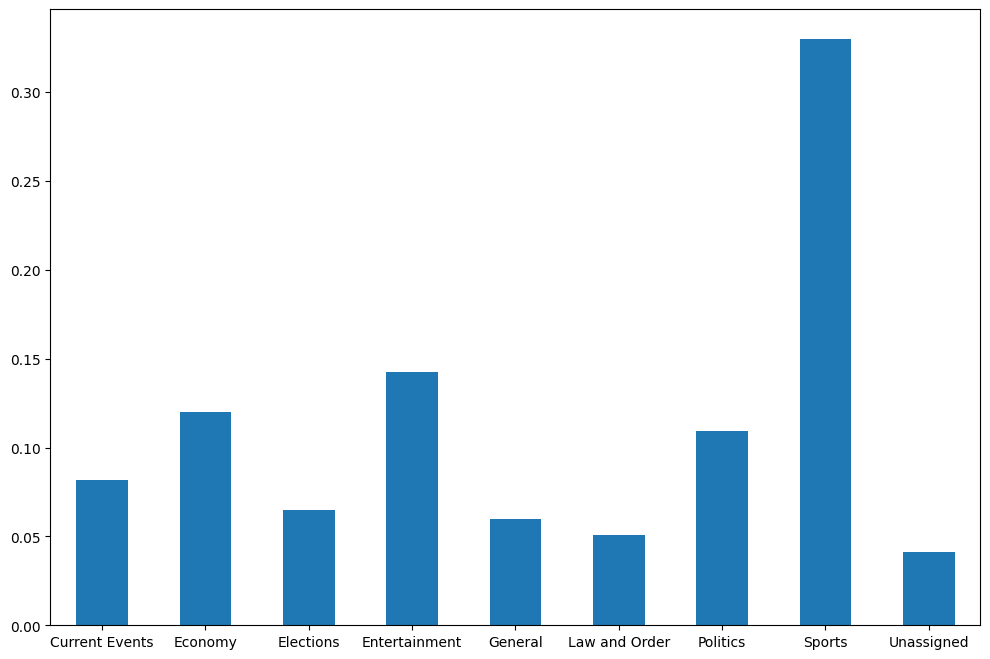

In [6]:
bins, counts = np.unique(data.topic_label, return_counts=True)
freq_series = pd.Series(counts/len(data.text_clean))
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_xticklabels(bins, rotation=0)
plt.show()

In [7]:
# Shuffle, then split the data into train and validation sets. Set the random_state 
# to 1 for reproducibility.
train_data, val_data, train_labels, val_labels = train_test_split(data.text_clean.astype(str), data.topic_label, train_size=0.8, random_state=42, stratify=data.topic_label) 
print('Training data size: {}'.format(len(train_data)))
print('Validation data size: {}'.format(len(val_data)))

Training data size: 362284
Validation data size: 90571


In [8]:
nlp = spacy.load('de_core_news_sm')
nlp.pipe_names
nlp = spacy.blank('de')

# There should be no pipeline components.
nlp.pipe_names
# For this exercise, we'll remove punctuation and spaces (which
# includes newlines), filter for tokens consisting of alphabetic
# characters only, and return the token text.
def spacy_tokenizer(doc):
  return [t.text for t in nlp(doc) if \
          not t.is_punct and \
          not t.is_space and \
          t.is_alpha]

In [9]:
vectorizer = TfidfVectorizer(tokenizer=spacy_tokenizer)
train_feature_vects = vectorizer.fit_transform(train_data)

c:\Users\rafid\Documents\Hertie School\40_Masters_Thesis\Empirical\.venv\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [10]:
# Instantiate a classifier with the default settings.
nb_classifier = MultinomialNB()
nb_classifier.fit(train_feature_vects, train_labels)
nb_classifier.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

In [11]:
# Get predictions on training set and calculate F1 score.
# See documentation above for more details on what "macro" means.
train_preds = nb_classifier.predict(train_feature_vects)
print('F1 score on initial training set: {}'.format(metrics.f1_score(train_labels, train_preds, average='macro')))

F1 score on initial training set: 0.8454209498885831


In [12]:
val_feature_vects = vectorizer.transform(val_data)

In [13]:
# Predict and evaluate.
val_preds = nb_classifier.predict(val_feature_vects)
print('F1 score on validation set: {}'.format(metrics.f1_score(val_labels, val_preds, average='macro')))

F1 score on validation set: 0.8133873232627901


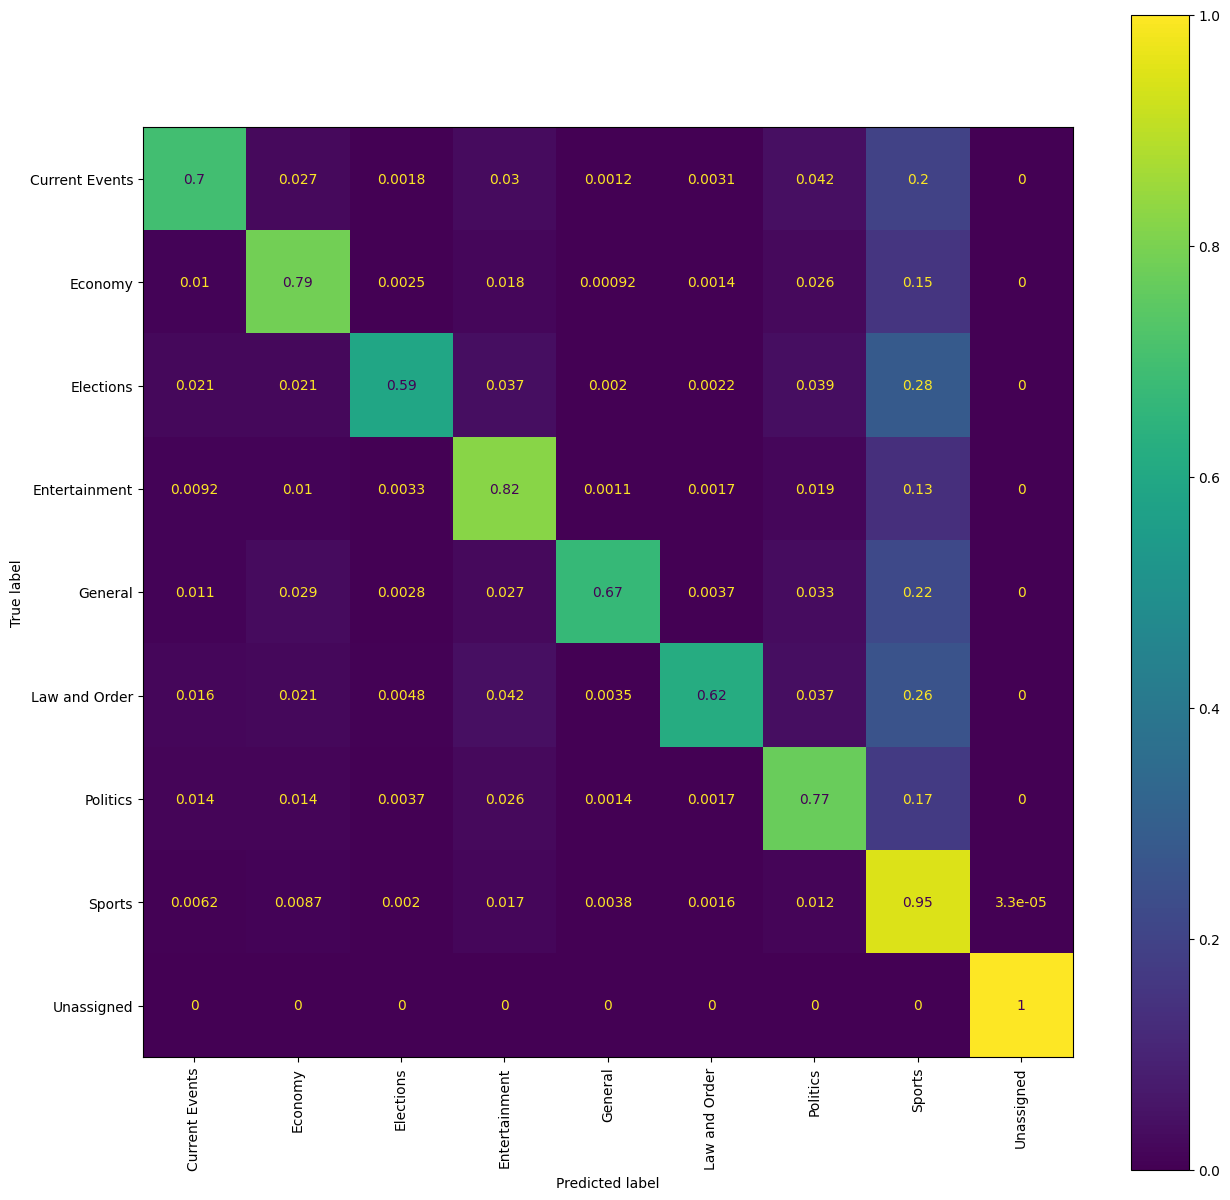

In [14]:
# Set the size of the plot.
fig, ax = plt.subplots(figsize=(15, 15))

# Create the confusion matrix. 
disp = ConfusionMatrixDisplay.from_estimator(nb_classifier, val_feature_vects, val_labels, normalize='true', display_labels=np.unique(data.topic_label), xticks_rotation='vertical', ax=ax)

In [15]:
target_names = sorted(data.topic_label.unique())

print(metrics.classification_report(val_labels, val_preds, target_names=target_names))


                precision    recall  f1-score   support

Current Events       0.86      0.70      0.77      7415
       Economy       0.88      0.79      0.83     10857
     Elections       0.94      0.59      0.73      5868
 Entertainment       0.86      0.82      0.84     12929
       General       0.95      0.67      0.79      5404
 Law and Order       0.95      0.62      0.75      4590
      Politics       0.81      0.77      0.79      9899
        Sports       0.73      0.95      0.82     29894
    Unassigned       1.00      1.00      1.00      3715

      accuracy                           0.82     90571
     macro avg       0.89      0.77      0.81     90571
  weighted avg       0.84      0.82      0.81     90571



## Voting Behaviour from Topics


In [18]:
# Simplified mapping: just number to name
party_label = {
    1: 'CDU/CSU',
    2: 'SPD',
    3: 'FDP',
    4: 'Bündnis 90/Die Grünen',
    5: 'Die Linke',
    6: 'AfD',
    0: 'Other',
}

# Map the party names to a new column
data['partylabel'] = data['secondvote'].map(party_label)


In [19]:
# Step 1: Split raw text (not yet vectorized)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(
    data.topic_label,
    data.partylabel,
    train_size=0.8,
    random_state=42,
    stratify=data.partylabel
)

print('Training data size: {}'.format(len(X_train_raw)))
print('Validation data size: {}'.format(len(X_val_raw)))

Training data size: 362284
Validation data size: 90571


In [20]:
from sklearn.feature_extraction.text import CountVectorizer


In [21]:
# Step 2: Vectorize the topic labels (i.e., your features)
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_raw)
X_val = vectorizer.transform(X_val_raw)

# Step 3: Train the model
nb_classifier2 = MultinomialNB()
nb_classifier2.fit(X_train, y_train)

MultinomialNB()

In [22]:
nb_classifier2.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

In [23]:
# Get predictions on training set and calculate F1 score (macro avg)
train_preds2 = nb_classifier2.predict(X_train)
print('F1 score on training set: {:.4f}'.format(metrics.f1_score(y_train, train_preds2, average='macro')))


F1 score on training set: 0.0965


In [24]:
# Predict and evaluate.
val_preds2 = nb_classifier2.predict(X_val)
print('F1 score on validation set: {:.4f}'.format(metrics.f1_score(y_val, val_preds2, average='macro')))

F1 score on validation set: 0.0975


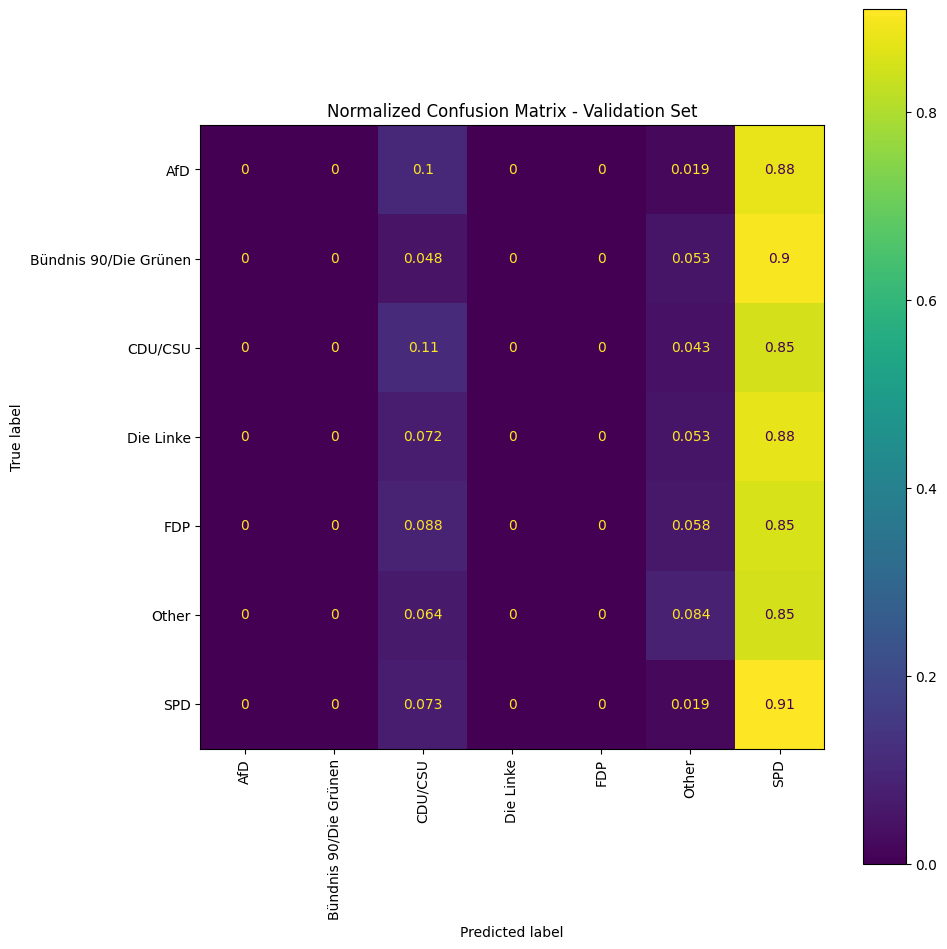

In [25]:
# Set the size of the plot.
fig, ax = plt.subplots(figsize=(10, 10))

# Create the confusion matrix.
ConfusionMatrixDisplay.from_estimator(
    nb_classifier2,
    X_val,
    y_val,
    normalize='true',
    display_labels=np.unique(y_val),
    xticks_rotation='vertical',
    ax=ax
)

plt.title("Normalized Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()

In [26]:
print(data['partylabel'].value_counts())



partylabel
SPD                      116470
CDU/CSU                   71773
AfD                       63431
Die Linke                 60259
Other                     59022
FDP                       52096
Bündnis 90/Die Grünen     29804
Name: count, dtype: int64


In [27]:
from sklearn.utils import resample

# Step 1: Group data by partylabel
grouped = data.groupby('partylabel')

# Step 2: Find the size of the smallest group
min_size = grouped.size().min()

# Step 3: Downsample all groups to min_size
balanced_data = grouped.apply(lambda x: resample(x, replace=False, n_samples=min_size, random_state=42))

# Step 4: Remove the multi-index caused by groupby + apply
balanced_data = balanced_data.droplevel(0).reset_index(drop=True)


C:\Users\rafid\AppData\Local\Temp\ipykernel_55364\3457917010.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = grouped.apply(lambda x: resample(x, replace=False, n_samples=min_size, random_state=42))


In [28]:
# Check counts per class
balanced_data['partylabel'].value_counts()


partylabel
AfD                      29804
Bündnis 90/Die Grünen    29804
CDU/CSU                  29804
Die Linke                29804
FDP                      29804
Other                    29804
SPD                      29804
Name: count, dtype: int64

In [29]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# Step 5: Set X (features) and y (labels)
X = balanced_data['topic_label']  # Features (text data)
y = balanced_data['partylabel']   # Labels (party labels)

# Step 6: Split the data into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.8, random_state=42, stratify=y
)

# Step 7: Create a CountVectorizer and vectorize the training and validation data
vectorizer = CountVectorizer()

# Vectorize the training data (X_train)
X_train_vect = vectorizer.fit_transform(X_train)

# Vectorize the validation data (X_val)
X_val_vect = vectorizer.transform(X_val)


In [30]:

from sklearn.naive_bayes import MultinomialNB

# Step 8: Instantiate the Naive Bayes classifier
nb_classifier = MultinomialNB()

# Step 9: Train the classifier on the training data
nb_classifier.fit(X_train_vect, y_train)


MultinomialNB()

F1 score on validation set: 0.18231914279010458


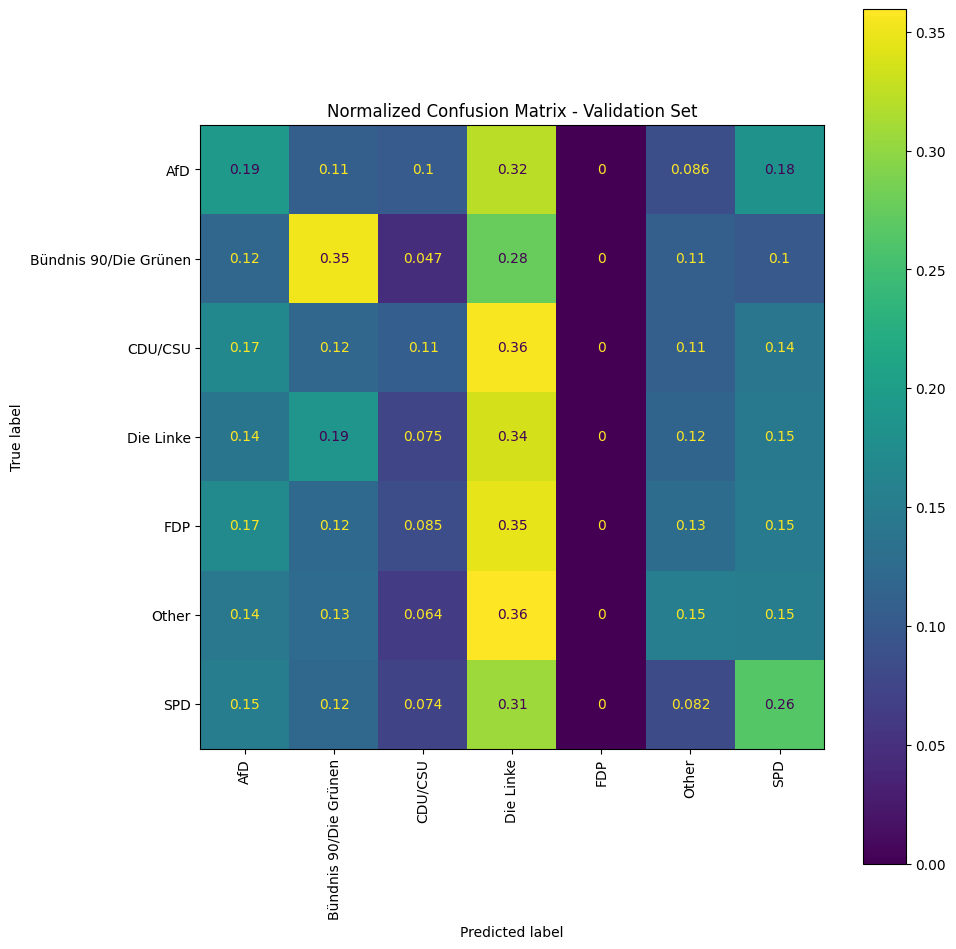

In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, f1_score
import matplotlib.pyplot as plt

# Step 10: Predict on the validation set
y_pred = nb_classifier.predict(X_val_vect)

# Step 11: Calculate and print the F1 score (macro average)
print(f'F1 score on validation set: {f1_score(y_val, y_pred, average="macro")}')

# Step 12: Plot the normalized confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))

# Create and plot the confusion matrix
ConfusionMatrixDisplay.from_estimator(
    nb_classifier, 
    X_val_vect, 
    y_val, 
    normalize='true', 
    display_labels=nb_classifier.classes_,
    xticks_rotation='vertical',
    ax=ax
)

# Set the title and display the plot
plt.title("Normalized Confusion Matrix - Validation Set")
plt.tight_layout()
plt.show()


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452855 entries, 0 to 452854
Data columns (total 37 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   personid                    452855 non-null  int64  
 1   urlid                       452519 non-null  object 
 2   duration                    452519 non-null  float64
 3   text_clean                  434278 non-null  object 
 4   secondvote                  452855 non-null  int64  
 5   vote_left                   452855 non-null  int64  
 6   vote_green                  452855 non-null  int64  
 7   vote_spd                    452855 non-null  int64  
 8   vote_na_other               452855 non-null  int64  
 9   vote_fdp                    452855 non-null  int64  
 10  vote_cdu                    452855 non-null  int64  
 11  vote_afd                    452855 non-null  int64  
 12  news_proportion             452855 non-null  float64
 13  age           

## Making into Wide Data

In [33]:
# Step 1: Drop the 'urlid' column as it's not needed for aggregation
#data = data.drop(columns=['urlid'])

# Step 2: Define the aggregation functions for each column
def aggregate_list(series):
    # Create a list from the values in the series
    return list(series.dropna())  # Drop NaNs before converting to list

# Step 3: Define the aggregation functions for the columns we want
agg_funcs = {
    'dominant_topic': aggregate_list,  # Create list for dominant_topic by 'personid'
    'dominant_topic_prob': aggregate_list,  # Create list for dominant_topic_prob by 'personid'
}

# Step 4: Aggregate the data by 'personid'
df = data.groupby('personid').agg(agg_funcs).reset_index()

# Step 5: Pivot 'topic_label' to get the counts of each label for each personid
# This will create one column per unique topic_label, with counts for each personid
topic_label_pivot = pd.get_dummies(data['topic_label']).groupby(data['personid']).sum()

# Step 6: Merge the pivoted topic_label counts with the other summary data
df = pd.merge(df, topic_label_pivot, on='personid', how='left')

# Step 7: Now, 'df' contains:
# - List for 'dominant_topic' and 'dominant_topic_prob'
# - Counts for each topic_label


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   personid             1344 non-null   int64 
 1   dominant_topic       1344 non-null   object
 2   dominant_topic_prob  1344 non-null   object
 3   Current Events       1344 non-null   int64 
 4   Economy              1344 non-null   int64 
 5   Elections            1344 non-null   int64 
 6   Entertainment        1344 non-null   int64 
 7   General              1344 non-null   int64 
 8   Law and Order        1344 non-null   int64 
 9   Politics             1344 non-null   int64 
 10  Sports               1344 non-null   int64 
 11  Unassigned           1344 non-null   int64 
dtypes: int64(10), object(2)
memory usage: 126.1+ KB


In [35]:
df.head()

,personid,dominant_topic,dominant_topic_prob,Current Events,Economy,Elections,Entertainment,General,Law and Order,Politics,Sports,Unassigned
0,598642,"[1.0, 5.0, 5.0, 1.0, 9.0, 9.0, 9.0, 2.0, 2.0, ...","[0.2507364749908447, 0.5197299122810364, 0.519...",126,40,99,58,27,31,80,159,0
1,598643,"[1.0, 1.0, 1.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, ...","[0.2164746522903442, 0.2164746522903442, 0.216...",9,7,5,55,1,13,11,37,10
2,599083,"[4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, 4.0, ...","[0.2543390095233917, 0.2543390691280365, 0.254...",2,2,28,3,0,1,7,21,11
3,599620,"[2.0, 8.0, 8.0, 2.0, 1.0, 1.0, 0.0, 5.0, 5.0, ...","[0.2669013440608978, 0.3594503402709961, 0.416...",4,33,2,4,0,7,2,6,0
4,599779,"[6.0, 3.0, 3.0, 3.0, 8.0, 3.0, 8.0, 3.0, 8.0, ...","[0.2939126789569855, 0.3400847315788269, 0.340...",5,1,3,3,0,7,8,10,0


In [36]:
wide = pd.read_csv('Processed_Data/51_textscored_wide.csv')

In [37]:
wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   personid                    1344 non-null   int64  
 1   duration                    1008 non-null   float64
 2   text_clean                  1008 non-null   object 
 3   secondvote                  1344 non-null   int64  
 4   vote_left                   1344 non-null   int64  
 5   vote_green                  1344 non-null   int64  
 6   vote_spd                    1344 non-null   int64  
 7   vote_na_other               1344 non-null   int64  
 8   vote_fdp                    1344 non-null   int64  
 9   vote_cdu                    1344 non-null   int64  
 10  vote_afd                    1344 non-null   int64  
 11  news_proportion             1344 non-null   float64
 12  age                         1344 non-null   int64  
 13  ml_gender_female            1344 

In [38]:
big_data = pd.merge(wide, df, on= 'personid', how='left')

In [39]:
big_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1344 entries, 0 to 1343
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   personid                    1344 non-null   int64  
 1   duration                    1008 non-null   float64
 2   text_clean                  1008 non-null   object 
 3   secondvote                  1344 non-null   int64  
 4   vote_left                   1344 non-null   int64  
 5   vote_green                  1344 non-null   int64  
 6   vote_spd                    1344 non-null   int64  
 7   vote_na_other               1344 non-null   int64  
 8   vote_fdp                    1344 non-null   int64  
 9   vote_cdu                    1344 non-null   int64  
 10  vote_afd                    1344 non-null   int64  
 11  news_proportion             1344 non-null   float64
 12  age                         1344 non-null   int64  
 13  ml_gender_female            1344 

In [40]:
big_data.to_csv('Processed_Data/81_TopicLDA_Wide.csv', index= False)